<a href="https://colab.research.google.com/github/raimamathew/Heart-Arrhythmia/blob/master/Review_1_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
x_train = pd.read_csv('/content/drive/My Drive/Heart Arrhythmia/mitbih_train.csv',header=None,usecols=range(187))
y_train = pd.read_csv('/content/drive/My Drive/Heart Arrhythmia/mitbih_train.csv',header=None,usecols=[187]).iloc[:,0]


In [0]:
x_test = pd.read_csv('/content/drive/My Drive/Heart Arrhythmia/mitbih_test.csv',header=None,usecols=range(187))
y_test = pd.read_csv('/content/drive/My Drive/Heart Arrhythmia/mitbih_test.csv',header=None,usecols=[187]).iloc[:,0]

In [0]:
from scipy.signal import gaussian, decimate
from scipy.sparse import csr_matrix

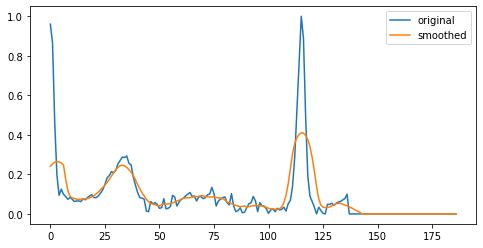

In [13]:
def gaussian_smoothing(data, window, std):
    gauss = gaussian(window ,std, sym=True)
    data = np.convolve(gauss/gauss.sum(), data, mode='same')
    return data

def gauss_wrapper(data):
    return gaussian_smoothing(data, 12, 7)

fig = plt.figure(figsize=(8,4))
plt.plot(x_train.iloc[1,:], label="original")
plt.plot(gauss_wrapper(x_train.iloc[1,:]), label="smoothed")
plt.legend()

In [0]:
def gradient(data, normalize=True):
    data = data.diff(axis=1, periods=3)
    if normalize:
        data = data.apply(lambda x: x/x.abs().max(), axis=1)
    return data

def preprocess(data): 
    data = data.abs().rolling(7, axis=1).max()
    data = data.fillna(method="bfill",axis=1)
    #data = np.apply_along_axis(gauss_wrapper, 1, data)
    data = decimate(data, axis=1, q=5)
    data[np.abs(data) < .05] = 0
    return pd.DataFrame(data)

x_train_grad = gradient(x_train)
x_test_grad = gradient(x_test)

x_train_preprocessed = preprocess(pd.concat([x_train, x_train_grad, gradient(x_train_grad)], axis=1))
x_test_preprocessed = preprocess(pd.concat([x_test, x_test_grad, gradient(x_test_grad)], axis=1))

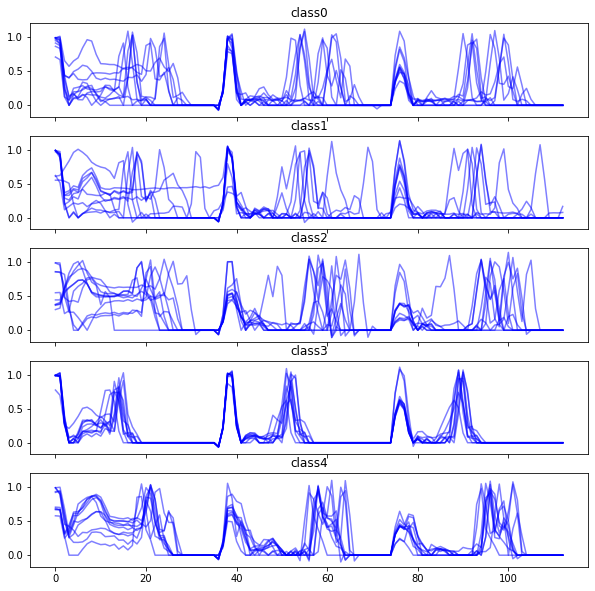

In [15]:
plot(x_train_preprocessed, y_train)

In [0]:
x_train_sparse = csr_matrix(x_train_preprocessed)

In [0]:
del x_train_grad
del x_test_grad

In [0]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

In [20]:
model = LogisticRegression(multi_class="ovr",solver="newton-cg", class_weight="balanced",
                          n_jobs=2, max_iter=150, C=.5)

start_time = time.time()
model.fit(x_train_sparse,y_train)
print("training time {}".format(time.time()-start_time))

training time 28.484288692474365


In [21]:
y_predict = model.predict(x_test_preprocessed)
cf = confusion_matrix(y_test,y_predict)
print("accuracy: " + str(accuracy_score(y_test,y_predict)))


accuracy: 0.8829709482916134


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, log_loss

rfc1 = RandomForestClassifier()
rfc1.fit(x_train_preprocessed, y_train)

y_pred = rfc1.predict(x_test_preprocessed)

yhat_pp = rfc1.predict_proba(x_test_preprocessed)
print('log loss:', log_loss(y_test, yhat_pp))

print(classification_report(y_test, y_pred,))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


log loss: 0.26019200111280966
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     18118
         1.0       0.97      0.60      0.74       556
         2.0       0.96      0.87      0.91      1448
         3.0       0.87      0.57      0.69       162
         4.0       0.99      0.94      0.96      1608

    accuracy                           0.97     21892
   macro avg       0.95      0.79      0.86     21892
weighted avg       0.97      0.97      0.97     21892



In [23]:
# XGBoost
import xgboost as xgb

model=xgb.XGBClassifier(random_state=1,learning_rate=0.1)
model.fit(x_train_preprocessed,y_train)
model.score(x_test_preprocessed,y_test)

y_pred = model.predict(x_test_preprocessed)

yhat_pp = model.predict_proba(x_test_preprocessed)
print('log loss:', log_loss(y_test, yhat_pp))
print(classification_report(y_test,y_pred))
# Slightly worse f1-score, but better log loss score than RFC

log loss: 0.13634752067782588
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     18118
         1.0       0.95      0.52      0.67       556
         2.0       0.96      0.79      0.87      1448
         3.0       0.76      0.52      0.62       162
         4.0       0.99      0.91      0.95      1608

    accuracy                           0.96     21892
   macro avg       0.92      0.75      0.82     21892
weighted avg       0.96      0.96      0.96     21892

